In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
#import statsmodels.tsa.stattools as ts
from init_objects import *
from functions.stylizedfacts import *
from functions.helpers import organise_data
#from functions.evolutionaryalgo import quadratic_loss_function
from functions.inequality import gini, lorenz_curve
from distribution_model import *
import statsmodels.api as sm
from SALib.sample import latin
from matplotlib import style
from collections import OrderedDict
from functions.indirect_calibration import distr_model_performance
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
from functions.find_bubbles import *
from statsmodels.iolib.summary2 import summary_col

# Results

To find out whether asset bubbles are associated with increased inequality, I first explore their correlation structure using Monte Carlo Simulations. This means that I simulate the model $N_{sim} = 500$ times in which the random number generator is initialized with a different seed. 

## Do asset bubbles increase inequality?
To find out, I first study the correlation structure of bubbles and inequality in Monte Carlo Simulations. 

In [2]:
with open('all_many_bubbles_output.json', 'r') as f:
    bubble_data = json.loads(f.read())

In [3]:
runs = len(bubble_data)
runs

28

First, I reorganize the data.

In [4]:
bubble_types = []
bubble_prices = []
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = [] 
horizons = [] 
learning_abilities = [] 
chartist_expectations = [] 
fundamentalist_expectations = []

for r in range(runs):
    if bubble_data[r][1]:
        bubble_types += bubble_data[r][0]
        bubble_prices += bubble_data[r][1]
        wealth_starts += bubble_data[r][2]
        wealth_ends += bubble_data[r][3]
        ginis_ot += bubble_data[r][4]
        palmas_ot += bubble_data[r][5]
        twtws_ot += bubble_data[r][6]
        risk_aversions += bubble_data[r][7]
        horizons += bubble_data[r][8]
        learning_abilities += bubble_data[r][9]
        chartist_expectations += bubble_data[r][10]
        fundamentalist_expectations += bubble_data[r][11]

In [5]:
unique_bubble_types = list(set(bubble_types))
unique_bubble_types

['bust', 'boom-bust', 'boom', 'bust-boom']

Then, I calculate the differences in inequality ratio's for every bubble.

In [6]:
my_indices = [idx for idx, p in enumerate(bubble_prices) if p]

# clean bubble series 
bubble_types = [bubble_types[i] for i in my_indices]
bubble_prices = [bubble_prices[i] for i in my_indices]
wealth_starts = [wealth_starts[i] for i in my_indices]
wealth_ends = [wealth_ends[i] for i in my_indices]
ginis_ot = [ginis_ot[i] for i in my_indices]
palmas_ot = [palmas_ot[i] for i in my_indices]
twtws_ot = [twtws_ot[i] for i in my_indices]

ginis_ot_dif = [g[-1] - g[0] for g in ginis_ot]
palmas_ot_dif = [g[-1] - g[0] for g in palmas_ot]
twtws_ot_dif = [g[-1] - g[0] for g in twtws_ot]

For every bubble, calculate the lenght and magnitude of the bubble.

In [7]:
bubble_lenght = [len(b) for b in bubble_prices]

# if boom or bust, magnitude is price difference 
bubble_magnitude = []
for idx, b_type in enumerate(bubble_types):
    if b_type in ['boom', 'bust']:
        bubble_magnitude.append(abs(bubble_prices[idx][-1] - bubble_prices[idx][0]))
    elif b_type in ['boom-bust', 'bust-boom']:
        bubble_magnitude.append(abs(np.mean(bubble_prices[idx]) - bubble_prices[idx][0]))
    else:
        #print(b_type)
        bubble_magnitude.append(pd.Series(bubble_prices[idx]).std())

In [8]:
# alternatively, just use the std in prices for all bubbles 
bubble_magnitude2 = []
for idx, b_type in enumerate(bubble_types):
    bubble_magnitude2.append(pd.Series(bubble_prices[idx]).std())

In [9]:
bubble_df = pd.DataFrame({'bubble_type': bubble_types, 'magnitude': bubble_magnitude2, 'lenght': bubble_lenght, 
              'gini_diff': ginis_ot_dif, 'palma_diff': palmas_ot_dif, 'twtw_diff': twtws_ot_dif})
bubble_df['const'] = 1
bubble_df['magn_len'] = bubble_df['magnitude'] * bubble_df['lenght']

In [10]:
bubble_df.head()

,bubble_type,magnitude,lenght,gini_diff,palma_diff,twtw_diff,const,magn_len
0,boom-bust,1.278567,7,0.000300,0.002984,0.003403,1,8.949970
1,boom-bust,1.894251,22,0.001042,0.003807,0.017565,1,41.673526
2,boom-bust,5.070751,26,0.001983,0.009473,0.072128,1,131.839532
3,bust-boom,4.080676,31,0.003291,0.019897,0.061842,1,126.500965
4,boom,9.318927,45,0.004013,0.031828,0.128899,1,419.351727


In [23]:
# regres gini_diff, palma_diff & twtw diff on magnitude, lenght & magnitude*lenght
gini_res = sm.OLS(endog=bubble_df['gini_diff'], exog=bubble_df[['const', 'magnitude']], missing='drop').fit()
palma_res = sm.OLS(endog=bubble_df['palma_diff'], exog=bubble_df[['const', 'magnitude']], missing='drop').fit()
twtw_res = sm.OLS(endog=bubble_df['twtw_diff'], exog=bubble_df[['const', 'magnitude']], missing='drop').fit()

In [24]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res, palma_res, twtw_res],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20'],
                            info_dict=info_dict,
                            regressor_order=['const', 'magnitude'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                         Table - OLS Regressions
                        Gini              Palma              20-20       
-------------------------------------------------------------------------
const            -0.0014            -0.2111***         -0.7432***        
                 (0.0029)           (0.0672)           (0.2454)          
magnitude        0.0012***          0.0320***          0.1191***         
                 (0.0001)           (0.0026)           (0.0094)          
R-squared        0.7485984273834476 0.8042451190815382 0.8095868131722288
No. observations 40                 40                 40                
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


## Experiment 1 



In [26]:
NRUNS = 5

In [27]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

Fix the learning ability for a clean experiment.

In [28]:
params['average_learning_ability'] = 0.0

Increment the share of chartists from 0.0 to 100

In [29]:
share_chartists = [x / 100.0 for x in range(0, 102, 2)]

Run model and update share chartists every time

In [ ]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    params['strat_share_chartists'] = share_chartists[seed]
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Structure the data

In [ ]:
ginis = []
palmas = []
twtws = []
asset_price_inflation = []
price_to_div_stdev = []

for idx, traders in enumerate(trdrs):
    #print(t)
    money = np.array([x.var.money[-1] for x in trdrs[idx]])
    stocks = np.array([x.var.stocks[-1] for x in trdrs[idx]])
    wealth = money + (stocks * orbs[idx].tick_close_price[-1])
    
    asset_price_inflation.append(orbs[idx].tick_close_price[-1] - orbs[idx].tick_close_price[0])
    price_to_div_stdev.append((pd.Series(orbs[idx].tick_close_price) / pd.Series(orbs[idx].fundamental[1:])).std())
    
    share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
    share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
    palmas.append(share_top_10 / share_bottom_40)
    
    share_top_20 = sum(np.sort(wealth)[int(len(wealth) * 0.8):]) / sum(wealth)
    share_bottom_20 = sum(np.sort(wealth)[:int(len(wealth) * 0.2)]) / sum(wealth)
    twtws.append(share_top_20 / share_bottom_20)
    
    ginis.append(gini(wealth))

In [ ]:
data = pd.DataFrame({'gini': np.log(ginis[1:]), 'palma': np.log(palmas[1:]), 'twtw': np.log(twtws[1:]), 'pd_vol': price_to_div_stdev[1:],
                     'share_chartists': np.log(share_chartists[1:]), 'lin_share_chartists': share_chartists[1:], 'asset_price_infl': asset_price_inflation[1:]})
data['const'] = 1

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[16,4])

ax1.scatter(range(len(ginis)), ginis)
ax2.scatter(range(len(palmas)), palmas)
ax3.scatter(range(len(twtws)), twtws)

ax3.set_title('Twenty-twenty ratio')
ax2.set_title('Palma ratio')
ax1.set_title('Gini coefficient')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation')

#fig.savefig('gini_palma_twenty_evolution_bubble.png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16,4])

ax1.scatter(range(len(asset_price_inflation)), asset_price_inflation)
ax2.scatter(range(len(price_to_div_stdev)), price_to_div_stdev)


ax1.set_title('asset_price_inflation')
ax2.set_title('price_to_div_stdev')

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel('Simulation')

In [ ]:
gini_res = sm.OLS(endog=data['gini'], exog=data[['const', 'share_chartists']], missing='drop').fit()
palma_res = sm.OLS(endog=data['palma'], exog=data[['const', 'share_chartists']], missing='drop').fit()
twtw_res = sm.OLS(endog=data['twtw'], exog=data[['const', 'share_chartists']], missing='drop').fit()
asset_p_inf_res = sm.OLS(endog=data['asset_price_infl'], exog=data[['const', 'lin_share_chartists']], missing='drop').fit()
pd_stdev_res = sm.OLS(endog=data['pd_vol'], exog=data[['const', 'lin_share_chartists']], missing='drop').fit()

In [ ]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[gini_res, palma_res, twtw_res, asset_p_inf_res, pd_stdev_res],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['Gini', 'Palma', '20-20', 'Asset-price inflation', 'Pd-volatility'],
                            info_dict=info_dict,
                            regressor_order=['const', 'share_chartists'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

# Experiment 2 Which agents benefit?

Calculate profits for all agents as the differences in wealth.

## Short baseline

In [ ]:
# total_strat_weight = trader.var.weight_fundamentalist[-1] + trader.var.weight_chartist[-1]
# c_share_strat = weight_chartist / total_strat_weight


In [45]:
profits = []
real_profits = []
market_returns = []
for idx, bubble in enumerate(bubble_types): 
    profits.append((np.array(wealth_ends[idx]) - np.array(wealth_starts[idx])) / np.array(wealth_starts[idx]))
    real_profits.append(np.array(wealth_ends[idx]) - np.array(wealth_starts[idx]))
    market_returns.append([(bubble_prices[idx][-1] - bubble_prices[idx][0]) / bubble_prices[idx][0] for x in range(len(wealth_starts[idx]))])

Profits contains profits of all agents for every bubble episode. What I need is every individual profit with the bubble type next to it.

In [89]:
all_profits = []
all_real_profits = []
all_bubbles = []
c_share_strat = []
learn_ab = []
hors = []
rav = []
w_starts = []
m_rets = []
potential_buy_hold_profits = []
for idx, p in enumerate(profits):
    all_profits += list(p)
    all_real_profits += list(real_profits[idx])
    m_rets += list(market_returns[idx])
    all_bubbles += [bubble_types[idx] for l in p]
    learn_ab += learning_abilities[idx]
    hors += horizons[idx]
    rav += risk_aversions[idx]
    w_starts += wealth_starts[idx]
    potential_buy_hold_profits += list(np.array(wealth_starts[idx]) * np.array(market_returns[idx]))
    c_share_strat += [np.mean(c_exp) / (np.mean(c_exp) + np.mean(f_exp)) for c_exp, f_exp in zip(chartist_expectations[idx], fundamentalist_expectations[idx])]

In [90]:
df1 = pd.DataFrame(all_profits)
df1['norm'] = (1 + df1[0])/2 # (-1,1] -> (0,1]
df1['lognorm'] = np.log(df1['norm'])

df_abs1 = pd.DataFrame(pd.Series(all_profits).abs())
df_abs1['norm'] = (1 + df_abs1[0])/2 # (-1,1] -> (0,1]
df_abs1['lognorm'] = np.log(df_abs1['norm'])

# df_real = pd.DataFrame(all_real_profits)
# df_real['norm'] = (1 + df_real[0])/2 # (-1,1] -> (0,1]
# df_real['lognorm'] = np.log(df_real['norm'])

In [91]:
redistr_df = pd.DataFrame({'wealth_change': all_profits, 'log_norm_wealth_change': df1['lognorm'], 'log_abs_profit': df_abs1['lognorm'],
                           'real_wealth_ch': all_real_profits, 'bubble_type': all_bubbles, 'risk_av': rav, 
                           'horizon': hors, 'learning': learn_ab, 'c_share_strat': c_share_strat, 'wealth_start': w_starts, 
                           'log_horizon': np.log(hors), 'm_rets': m_rets, 'buyhold_profit': potential_buy_hold_profits})
redistr_df['abs_profit'] = redistr_df['wealth_change'].abs()
redistr_df['positive_profit'] = redistr_df['wealth_change'] > 0
redistr_df['outperformed_market'] = redistr_df['wealth_change'] > redistr_df['m_rets'] 
redistr_df['const'] = 1

In [62]:
#redistr_df = pd.get_dummies(redistr_df, columns = ['positive_profit'])

In [63]:
#redistr_df['wealth_start_positive'] = redistr_df['positive_profit_True'] * redistr_df['wealth_start']
#redistr_df['wealth_start_negative'] = redistr_df['positive_profit_False'] * redistr_df['wealth_start']

In [92]:
redistr_df.head(10)

,wealth_change,log_norm_wealth_change,log_abs_profit,real_wealth_ch,bubble_type,risk_av,horizon,learning,c_share_strat,wealth_start,log_horizon,m_rets,buyhold_profit,abs_profit,positive_profit,outperformed_market,const
0,0.010251,-0.682948,-0.682948,49.179709,boom-bust,0.789059,43,0.118615,0.366942,4797.418459,3.761200,0.013146,63.066047,0.010251,True,False,1
1,0.000000,-0.693147,-0.693147,0.000000,boom-bust,1.287427,124,0.298143,0.508778,5973.838099,4.820282,0.013146,78.531059,0.000000,False,False,1
2,0.010559,-0.682644,-0.682644,100.408572,boom-bust,1.140765,19,0.724937,0.542054,9509.291513,2.944439,0.013146,125.007528,0.010559,True,False,1
3,0.010111,-0.683086,-0.683086,122.949272,boom-bust,0.924572,86,0.461712,0.503843,12159.393139,4.454347,0.013146,159.845313,0.010111,True,False,1
4,0.010464,-0.682738,-0.682738,127.047581,boom-bust,1.139736,115,0.777666,0.530438,12141.839896,4.744932,0.013146,159.614561,0.010464,True,False,1
5,-0.000988,-0.694136,-0.692160,-22.527102,boom-bust,0.835647,69,0.650943,0.494503,22797.145270,4.234107,0.013146,299.687393,0.000988,False,False,1
6,0.009946,-0.683250,-0.683250,173.967690,boom-bust,1.256892,150,0.306482,0.816651,17491.432077,5.010635,0.013146,229.939390,0.009946,True,False,1
7,0.000000,-0.693147,-0.693147,0.000000,boom-bust,1.204918,15,0.498636,0.472196,14210.489080,2.708050,0.013146,186.808672,0.000000,False,False,1
8,0.010433,-0.682768,-0.682768,57.376327,boom-bust,1.723577,190,0.303485,0.401522,5499.348728,5.247024,0.013146,72.293503,0.010433,True,False,1
9,0.000000,-0.693147,-0.693147,0.000000,boom-bust,1.392093,94,0.034381,0.244219,9515.871117,4.543295,0.013146,125.094023,0.000000,False,False,1


## Scatter plot

Relative and absolute wealth changes

Text(0, 0.5, 'wealth_start')

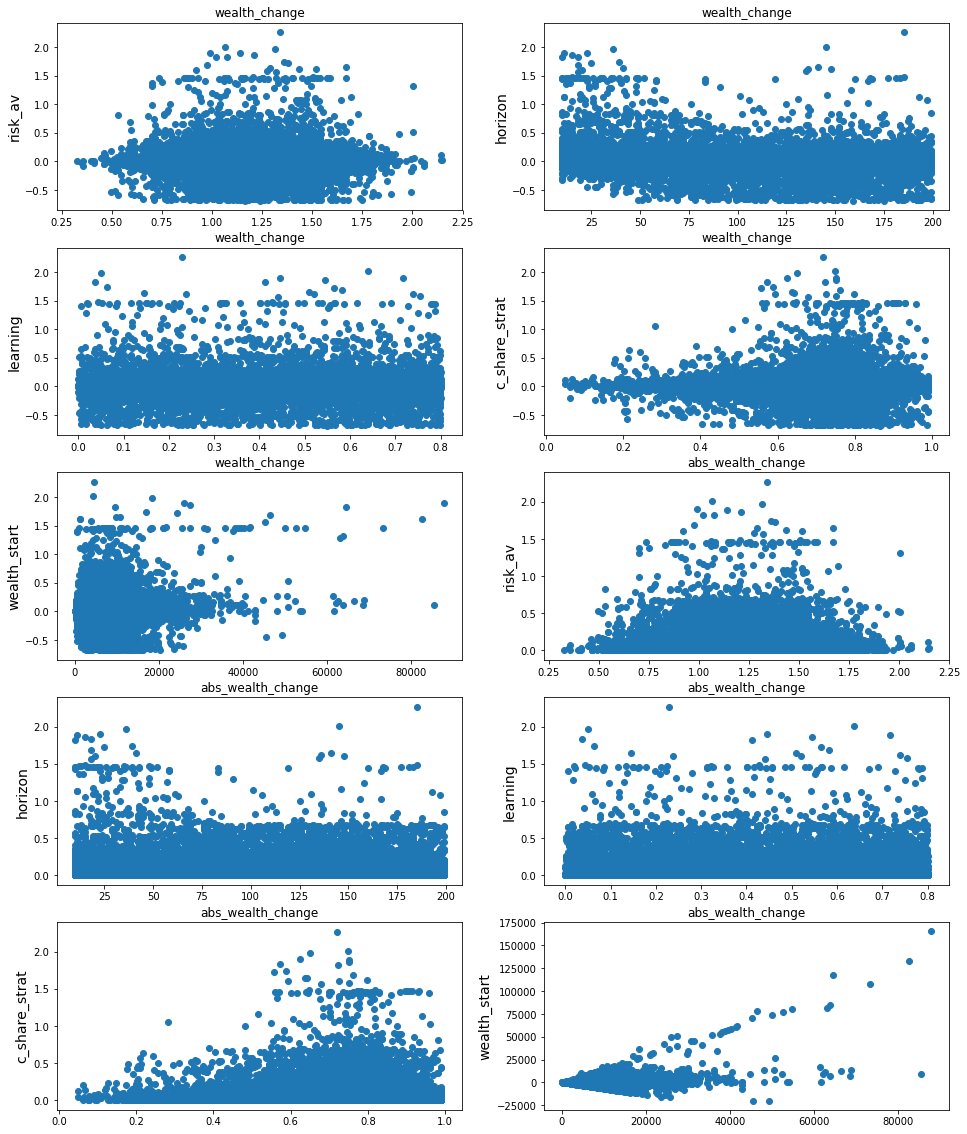

In [44]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=[16,20])

ax1.scatter(redistr_df['risk_av'], redistr_df['wealth_change'])
ax2.scatter(redistr_df['horizon'], redistr_df['wealth_change'])
ax3.scatter(redistr_df['learning'], redistr_df['wealth_change'])
ax4.scatter(redistr_df['c_share_strat'], redistr_df['wealth_change']) #TODO have a fraction here of chart vs fund
ax5.scatter(redistr_df['wealth_start'], redistr_df['wealth_change'])
#ax6.scatter(redistr_df['wealth_start_positive'], redistr_df['real_wealth_ch'])

ax6.scatter(redistr_df['risk_av'], redistr_df['abs_profit'])
ax7.scatter(redistr_df['horizon'], redistr_df['abs_profit'])
ax8.scatter(redistr_df['learning'], redistr_df['abs_profit'])
ax9.scatter(redistr_df['c_share_strat'], redistr_df['abs_profit']) #TODO have a fraction here of chart vs fund
ax10.scatter(redistr_df['wealth_start'], redistr_df['abs_profit'])


ax1.set_title('wealth_change')
ax2.set_title('wealth_change')
ax3.set_title('wealth_change')
ax4.set_title('wealth_change')
ax5.set_title('wealth_change')

ax6.set_title('abs_wealth_change')
ax7.set_title('abs_wealth_change')
ax8.set_title('abs_wealth_change')
ax9.set_title('abs_wealth_change')
ax10.set_title('abs_wealth_change')

ax1.set_ylabel('risk_av', fontsize=14)
ax2.set_ylabel('horizon', fontsize=14)
ax3.set_ylabel('learning', fontsize=14)
ax4.set_ylabel('c_share_strat', fontsize=14)
ax5.set_ylabel('wealth_start', fontsize=14)
ax6.set_ylabel('risk_av', fontsize=14)
ax7.set_ylabel('horizon', fontsize=14)
ax8.set_ylabel('learning', fontsize=14)
ax9.set_ylabel('c_share_strat', fontsize=14)
ax10.set_ylabel('wealth_start', fontsize=14)

In [134]:
# 2 regression
reg1 = sm.OLS(endog=redistr_df['log_norm_wealth_change'], exog=redistr_df[['const', 'risk_av', 'log_horizon', 'learning', 'c_share_strat', 'wealth_start']], missing='drop').fit()
reg2 = sm.OLS(endog=redistr_df['log_abs_profit'], exog=redistr_df[['const', 'risk_av', 'log_horizon', 'learning', 'c_share_strat', 'wealth_start']], missing='drop').fit()
reg3 = sm.OLS(endog=redistr_df['real_wealth_ch'], exog=redistr_df[['const', 'risk_av', 'log_horizon', 'learning', 'c_share_strat', 'wealth_start']], missing='drop').fit()

In [135]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[reg1, reg2, reg3],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['% Profit', '% Profit abs', 'wealth change'],
                            info_dict=info_dict,
                            regressor_order=['const', 'risk_av', 'log_horizon', 'learning', 'c_share_strat', 'wealth_start'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                          Table - OLS Regressions
                       % Profit          % Profit abs       wealth change   
----------------------------------------------------------------------------
const            -0.5447***          -0.7515***          -756.5343***       
                 (0.0129)            (0.0081)            (220.8773)         
risk_av          0.0020              -0.0040             61.7397            
                 (0.0055)            (0.0035)            (93.7314)          
log_horizon      -0.0337***          -0.0017             -299.2682***       
                 (0.0019)            (0.0012)            (32.6849)          
learning         -0.0002             -0.0153***          -185.4670*         
                 (0.0057)            (0.0036)            (97.9635)          
c_share_strat    -0.0397***          0.2210***           1049.4971***       
                 (0.0091)            (0.0058)            (156.3877)         
wealth_start     0.0000***

## Long baseline

In [236]:
NRUNS = 12

In [237]:
with open('parameters.json', 'r') as f:
    params = json.loads(f.read())

In [238]:
params['ticks'] = 4000
params['strat_share_chartists'] = 0.9

In [239]:
trdrs = []
orbs = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs.append(traders)
    orbs.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11


In [240]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(orbs)

In [241]:
wealth_starts = []
wealth_ends = []
ginis_ot = []
palmas_ot = []
twtws_ot = []
risk_aversions = []
horizons = []
learning_abilities = []
chartist_expectations = []
fundamentalist_expectations = []
profits = []
real_profits = []
market_returns = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs[seed].tick_close_price[-1])
    
    # profits
    profits.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))
    real_profits.append(np.array(wealth_end) - np.array(wealth_start))
    market_returns.append([(orbs[seed].tick_close_price[-1] - orbs[seed].tick_close_price[0]) / orbs[seed].tick_close_price[0] for x in range(len(wealth_start))])

    # determine characteristics of the agents
    risk_aversions.append([x.par.risk_aversion for x in traders])
    horizons.append([x.par.horizon for x in traders])
    learning_abilities.append([x.par.learning_ability for x in traders])
    chartist_expectations.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs[seed].tick_close_price[0])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts.append(list(wealth_start))
    wealth_ends.append(list(wealth_end))
    ginis_ot.append(wealth_gini_over_time)
    palmas_ot.append(palma_over_time)
    twtws_ot.append(twentytwenty_over_time)

In [132]:
fundamentalist_component_at_t = 0
for x in trdrs[0]:
    fundamentalist_component_at_t += np.array(x.var.weight_fundamentalist)

In [133]:
fundamentalist_components = [np.array(x.var.weight_fundamentalist) for x in trdrs[0]]
chartist_components = [np.array(x.var.weight_chartist) for x in trdrs[0]]
random_components = [np.array(x.var.weight_random) for x in trdrs[0]]

In [134]:
fundamentalist_sentiment = sum(fundamentalist_components)
chartist_sentiment = sum(chartist_components)
random_sentiment = sum(random_components)
total_sentiment = fundamentalist_sentiment + chartist_sentiment + random_sentiment

In [143]:
all_profits = []
all_real_profits = []
c_share_strat = []
all_seeds = []
chart_exp = []
fund_exp = []
learn_ab = []
hors = []
rav = []
w_starts = []
m_rets = []
potential_buy_hold_profits = []
for idx, p in enumerate(profits):
    all_profits += list(p)
    all_real_profits += list(real_profits[idx])
    learn_ab += learning_abilities[idx]
    m_rets += market_returns[idx]
    hors += horizons[idx]
    rav += risk_aversions[idx]
    w_starts += wealth_starts[idx]
    #chart_exp += [np.mean(c_exp) for c_exp in chartist_expectations[idx]]
    #fund_exp += [np.mean(f_exp) for f_exp in fundamentalist_expectations[idx]]
    potential_buy_hold_profits += list(np.array(wealth_starts[idx]) * np.array(market_returns[idx]))
    all_seeds += [idx for c_exp in chartist_expectations[idx]]
    c_share_strat += [np.mean(c_exp) / (np.mean(c_exp) + np.mean(f_exp)) for c_exp, f_exp in zip(chartist_expectations[idx], fundamentalist_expectations[idx])]

In [144]:
df = pd.DataFrame(all_profits)
df['norm'] = (1 + df[0])/2 # (-1,1] -> (0,1]
df['lognorm'] = np.log(df['norm'])

df_abs = pd.DataFrame(pd.Series(all_profits).abs())
df_abs['norm'] = (1 + df_abs[0])/2 # (-1,1] -> (0,1]
df_abs['lognorm'] = np.log(df_abs['norm'])

# df_real = pd.DataFrame(all_real_profits)
# df_real['norm'] = (1 + df_real[0])/2 # (-1,1] -> (0,1]
# df_real['lognorm'] = np.log(df_real['norm'])

In [140]:
#df_real['norm']

In [145]:
redistr_df_long = pd.DataFrame({'wealth_change': all_profits, 'log_norm_wealth_change': df['lognorm'], 
                                'log_abs_profit': df_abs['lognorm'], 'market_ret': m_rets,
                                'real_wealth_ch': all_real_profits, 'risk_av': rav, 
                                'horizon': hors, 'log_horizon': np.log(hors), 'buyhold_profit': potential_buy_hold_profits,
                                'learning': learn_ab, 'c_share_strat': c_share_strat, 'wealth_start': w_starts})
redistr_df_long['abs_profit'] = redistr_df_long['wealth_change'].abs()
#redistr_df_long['log_abs_profit'] = np.log(redistr_df_long['abs_profit'])
redistr_df_long['positive_profit'] = redistr_df_long['wealth_change'] > 0
redistr_df_long['outperformed_market'] = redistr_df_long['wealth_change'] > redistr_df_long['market_ret'] 
redistr_df_long['const'] = 1

In [146]:
redistr_df_long.tail()

,wealth_change,log_norm_wealth_change,log_abs_profit,market_ret,real_wealth_ch,risk_av,horizon,log_horizon,buyhold_profit,learning,c_share_strat,wealth_start,abs_profit,positive_profit,outperformed_market,const
2995,-0.935650,-3.436561,-0.032704,0.045998,-10138.132289,7.809646,20,2.995732,498.409689,1.000000,0.586822,10835.393130,0.935650,False,False,1
2996,-0.976776,-4.455712,-0.011680,0.045998,-7849.344813,4.112951,72,4.276666,369.641117,1.000000,0.580621,8035.973038,0.976776,False,False,1
2997,-0.980551,-4.633114,-0.009772,0.045998,-4735.382968,7.582602,50,3.912023,222.139946,0.927683,0.571029,4829.307486,0.980551,False,False,1
2998,-0.982947,-4.764575,-0.008563,0.045998,-4478.546922,6.009706,27,3.295837,209.579520,0.972257,0.581907,4556.244687,0.982947,False,False,1
2999,-0.966862,-4.100235,-0.016708,0.045998,-6486.216057,7.920506,23,3.135494,308.580529,0.969447,0.605952,6708.519947,0.966862,False,False,1


Text(0, 0.5, 'wealth_start')

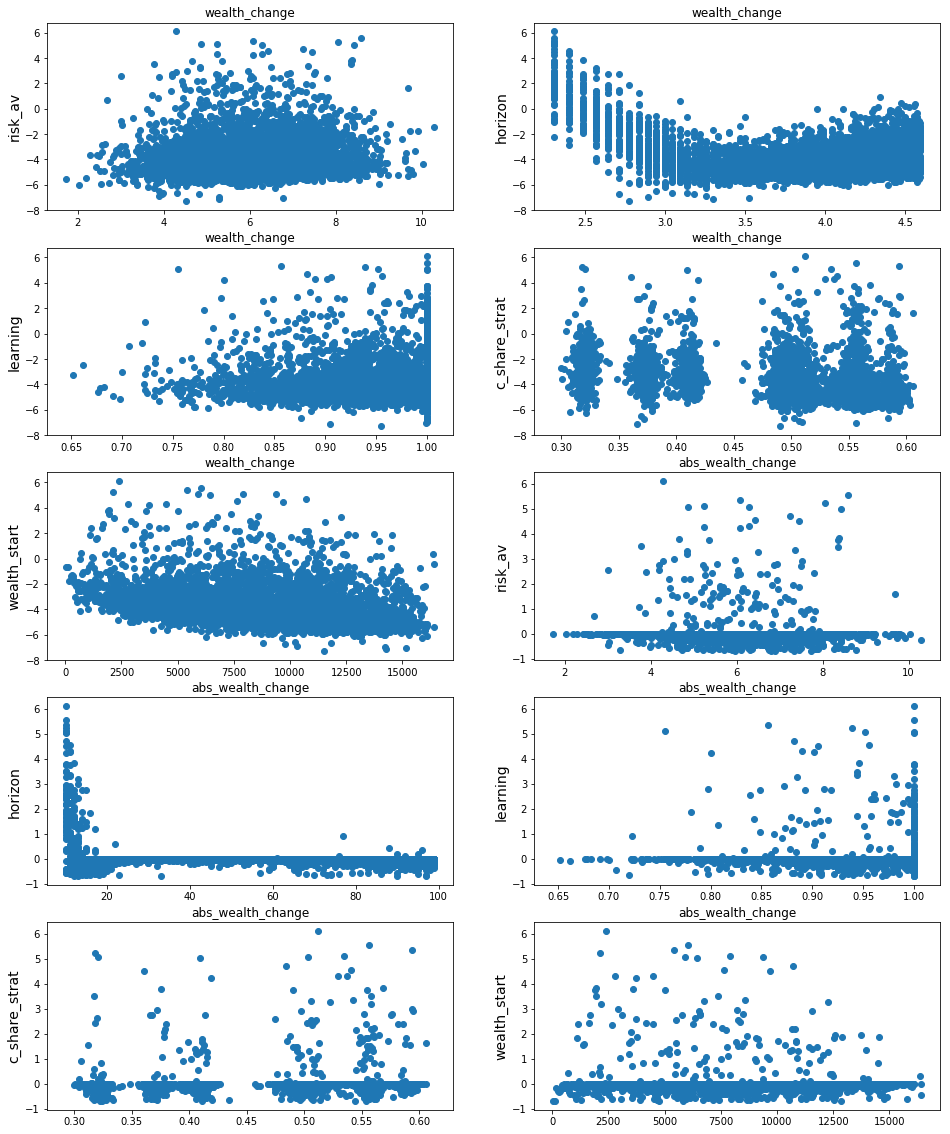

In [112]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2, figsize=[16,20])

ax1.scatter(redistr_df_long['risk_av'], redistr_df_long['log_norm_wealth_change'])
ax2.scatter(redistr_df_long['log_horizon'], redistr_df_long['log_norm_wealth_change'])
ax3.scatter(redistr_df_long['learning'], redistr_df_long['log_norm_wealth_change'])
ax4.scatter(redistr_df_long['c_share_strat'], redistr_df_long['log_norm_wealth_change']) #TODO have a fraction here of chart vs fund
ax5.scatter(redistr_df_long['wealth_start'], redistr_df_long['log_norm_wealth_change'])
#ax6.scatter(redistr_df['wealth_start_positive'], redistr_df['real_wealth_ch'])

ax6.scatter(redistr_df_long['risk_av'], redistr_df_long['log_abs_profit'])
ax7.scatter(redistr_df_long['horizon'], redistr_df_long['log_abs_profit'])
ax8.scatter(redistr_df_long['learning'], redistr_df_long['log_abs_profit'])
ax9.scatter(redistr_df_long['c_share_strat'], redistr_df_long['log_abs_profit']) #TODO have a fraction here of chart vs fund
ax10.scatter(redistr_df_long['wealth_start'], redistr_df_long['log_abs_profit'])


ax1.set_title('wealth_change')
ax2.set_title('wealth_change')
ax3.set_title('wealth_change')
ax4.set_title('wealth_change')
ax5.set_title('wealth_change')

ax6.set_title('abs_wealth_change')
ax7.set_title('abs_wealth_change')
ax8.set_title('abs_wealth_change')
ax9.set_title('abs_wealth_change')
ax10.set_title('abs_wealth_change')

ax1.set_ylabel('risk_av', fontsize=14)
ax2.set_ylabel('horizon', fontsize=14)
ax3.set_ylabel('learning', fontsize=14)
ax4.set_ylabel('c_share_strat', fontsize=14)
ax5.set_ylabel('wealth_start', fontsize=14)
ax6.set_ylabel('risk_av', fontsize=14)
ax7.set_ylabel('horizon', fontsize=14)
ax8.set_ylabel('learning', fontsize=14)
ax9.set_ylabel('c_share_strat', fontsize=14)
ax10.set_ylabel('wealth_start', fontsize=14)

In [113]:
# 2 regression
reg1_long = sm.OLS(endog=redistr_df_long['log_norm_wealth_change'], exog=redistr_df_long[['const', 'risk_av', 'log_horizon', 'learning', 'c_share_strat', 'wealth_start']], missing='drop').fit()
reg2_long = sm.OLS(endog=redistr_df_long['log_abs_profit'], exog=redistr_df_long[['const', 'risk_av', 'log_horizon', 'learning', 'c_share_strat', 'wealth_start']], missing='drop').fit()
reg3_long = sm.OLS(endog=redistr_df_long['real_wealth_ch'], exog=redistr_df_long[['const', 'risk_av', 'log_horizon', 'learning', 'c_share_strat', 'wealth_start']], missing='drop').fit()

In [116]:
info_dict={'R-squared' : lambda x: "{}".format(x.rsquared), 
           'No. observations' : lambda x: "{}".format(int(x.nobs))}

results_table = summary_col(results=[reg1_long, reg2_long, reg3_long],
                            float_format='%0.4f',
                            stars = True,
                            model_names=['log % Profit', 'log % Profit abs', 'wealth change'],
                            info_dict=info_dict,
                            regressor_order=['const', 'risk_av', 'log_horizon', 'learning', 'c_share_strat', 'wealth_start'])

results_table.add_title('Table - OLS Regressions')

print(results_table)

                          Table - OLS Regressions
                     log % Profit      log % Profit abs     wealth change   
----------------------------------------------------------------------------
const            3.2616***           0.8831***           188714.3253***     
                 (0.3530)            (0.1065)            (28949.3088)       
risk_av          0.1074***           -0.0074             1169.6216          
                 (0.0151)            (0.0046)            (1237.0640)        
log_horizon      -0.8358***          -0.1920***          -32724.9395***     
                 (0.0308)            (0.0093)            (2521.9165)        
learning         -0.4602             -0.2046**           -59007.9998**      
                 (0.3120)            (0.0942)            (25588.2058)       
c_share_strat    -6.1749***          0.2861***           -1478.8382         
                 (0.2145)            (0.0647)            (17593.0726)       
wealth_start     -0.0001**

# Experiment 3:

Do many agents lose a little, while a win a lot? 

How to test... 

* there are many small losses 
* there are a few big winners

## Short baseline

In [147]:
# categorize winners and losers, 
# measure count, and measure size 
winners_and_losers_short = redistr_df[['real_wealth_ch', 'buyhold_profit', 'positive_profit', 'outperformed_market']][redistr_df['real_wealth_ch'] != 0]
winners_and_losers_short['wealth_change_from_trading'] = winners_and_losers_short['real_wealth_ch'] - winners_and_losers_short['buyhold_profit']

In [67]:
winners = np.sum(winners_and_losers_short['outperformed_market'])
losers = len(winners_and_losers_short['outperformed_market']) - winners

In [71]:
print('winners: ', winners)
print('losers: ', losers)

winners:  5905
losers:  10682


In [97]:
# size winners
winner_wealth_change = winners_and_losers_short['wealth_change_from_trading'][winners_and_losers_short['outperformed_market'] == True]
loser_wealth_change = winners_and_losers_short['wealth_change_from_trading'][winners_and_losers_short['outperformed_market'] == False]

In [100]:
print('av winner wealth change: ', np.mean(winner_wealth_change))
print('av loser wealth change: ', np.mean(loser_wealth_change))

av winner wealth change:  768.564281939519
av loser wealth change:  -1013.1796477112582


In [117]:
winner_wealth_change.describe()

count     5905.000000
mean       768.564282
std       1841.989055
min          0.048978
25%         60.071997
50%        238.374544
75%        711.626827
max      33961.837221
Name: wealth_change_from_trading, dtype: float64

In [114]:
loser_wealth_change.abs().describe()

count    10682.000000
mean      1013.179648
std       2243.443566
min          0.008738
25%         78.137055
50%        310.629845
75%        953.558472
max      46882.335253
Name: wealth_change_from_trading, dtype: float64

## Long baseline

In [148]:
# categorize winners and losers, 
# measure count, and measure size 
winners_and_losers_long = redistr_df_long[['real_wealth_ch', 'buyhold_profit', 'positive_profit', 'outperformed_market']][redistr_df_long['real_wealth_ch'] != 0]
winners_and_losers_long['wealth_change_from_trading'] = winners_and_losers_short['real_wealth_ch'] - winners_and_losers_short['buyhold_profit']

In [149]:
winners_l = np.sum(winners_and_losers_long['outperformed_market'])
losers_l = len(winners_and_losers_long['outperformed_market']) - winners_l

In [151]:
print('winners: ', winners_l)
print('losers: ', losers_l)

winners:  138
losers:  2860


In [164]:
winner_wealth_change_l = winners_and_losers_long['real_wealth_ch'][winners_and_losers_long['positive_profit'] == True]
loser_wealth_change_l = winners_and_losers_long['real_wealth_ch'][winners_and_losers_long['positive_profit'] == False]

In [165]:
print('av winner wealth change: ', np.mean(winner_wealth_change_l))
print('av loser wealth change: ', np.mean(loser_wealth_change_l))

av winner wealth change:  157737.73980354477
av loser wealth change:  -7582.720080200152


In [167]:
winner_wealth_change_l.describe()

count    1.380000e+02
mean     1.577377e+05
std      4.893884e+05
min      5.343905e+01
25%      3.462120e+03
50%      1.531533e+04
75%      8.119902e+04
max      3.095999e+06
Name: real_wealth_ch, dtype: float64

## Mann Whitney U test of different means

In [176]:
print("U statistic = ", stats.mannwhitneyu(winner_wealth_change_l, loser_wealth_change_l)[0])
print("p-value = ", stats.mannwhitneyu(winner_wealth_change_l, loser_wealth_change_l)[1])

U statistic =  0.0
p-value =  3.713701944938883e-88


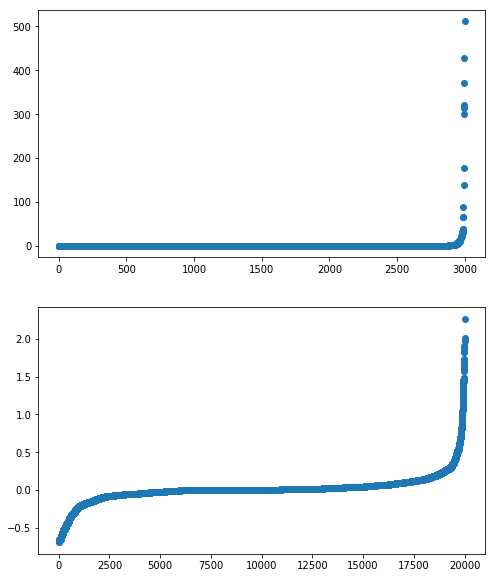

In [199]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=[8,10])

ax1.scatter(range(len(redistr_df_long['wealth_change'].sort_values())), redistr_df_long['wealth_change'].sort_values())

ax2.scatter(range(len(redistr_df['wealth_change'].sort_values())), redistr_df['wealth_change'].sort_values())

In [200]:
redistr_df_long['wealth_change'].describe()

count    3000.000000
mean        0.336792
std        17.862809
min        -0.998420
25%        -0.981115
50%        -0.959719
75%        -0.889686
max       511.219539
Name: wealth_change, dtype: float64

In [205]:
print('long skew = ', redistr_df_long['wealth_change'].skew())
print('long kurtosis = ', redistr_df_long['wealth_change'].kurtosis())

long skew =  21.19477977760495
long kurtosis =  488.4613729408002


In [201]:
redistr_df['wealth_change'].describe()

count    20000.000000
mean         0.014106
std          0.186853
min         -0.685029
25%         -0.022648
50%          0.000000
75%          0.042881
max          2.264974
Name: wealth_change, dtype: float64

In [206]:
print('short skew = ', redistr_df['wealth_change'].skew())
print('short kurtosis = ', redistr_df['wealth_change'].kurtosis())

short skew =  2.3452120839906327
short kurtosis =  21.576779502849792


### Simulate the model without budget constraints

In [242]:
params['strat_share_chartists'] = 0.0
params['fundamentalist_horizon_multiplier'] = 0.5
params['average_learning_ability'] = 0.0
params['mutation_intensity'] = 0.0

In [243]:
trdrs_f = []
orbs_f = []
for seed in range(NRUNS): 
    traders, orderbook = init_objects_distr(params, seed)
    traders, orderbook = pb_distr_model(traders, orderbook, params, seed)
    trdrs_f.append(traders)
    orbs_f.append(orderbook)

Start of simulation  0
Start of simulation  1
Start of simulation  2
Start of simulation  3
Start of simulation  4
Start of simulation  5
Start of simulation  6
Start of simulation  7
Start of simulation  8
Start of simulation  9
Start of simulation  10
Start of simulation  11


In [244]:
mc_prices_f, mc_returns_f, mc_autocorr_returns_f, mc_autocorr_abs_returns_f, mc_volatility_f, mc_volume_f, mc_fundamentals_f = organise_data(orbs_f)

In [245]:
wealth_starts_f = []
wealth_ends_f = []
ginis_ot_f = []
palmas_ot_f = []
twtws_ot_f = []
risk_aversions_f = []
horizons_f = []
learning_abilities_f = []
chartist_expectations_f = []
fundamentalist_expectations_f = []
profits_f = []

# determine the start and end wealth of the bubble
for seed, traders in enumerate(trdrs_f):
    money_start = np.array([x.var.money[0] for x in traders])
    stocks_start = np.array([x.var.stocks[0] for x in traders])
    wealth_start = money_start + (stocks_start * orbs_f[seed].tick_close_price[0])

    money_end = np.array([x.var.money[-1] for x in traders])
    stocks_end = np.array([x.var.stocks[-1] for x in traders])
    wealth_end = money_end + (stocks_end * orbs_f[seed].tick_close_price[-1])
    
    # profits
    profits_f.append((np.array(wealth_end) - np.array(wealth_start)) / np.array(wealth_start))

    # determine characteristics of the agents
    risk_aversions_f.append([x.par.risk_aversion for x in traders])
    horizons_f.append([x.par.horizon for x in traders])
    learning_abilities_f.append([x.par.learning_ability for x in traders])
    chartist_expectations_f.append([x.var.weight_chartist[: ] for x in traders])
    fundamentalist_expectations_f.append([x.var.weight_fundamentalist[:] for x in traders])

    wealth_gini_over_time = []
    palma_over_time = []
    twentytwenty_over_time = []
    for t in range(params['ticks']):
        money = np.array([x.var.money[t] for x in traders])
        stocks = np.array([x.var.stocks[t] for x in traders])
        wealth = money + (stocks * orbs_f[0].tick_close_price[t])

        share_top_10 = sum(np.sort(wealth)[int(len(wealth) * 0.9):]) / sum(wealth)
        share_bottom_40 = sum(np.sort(wealth)[:int(len(wealth) * 0.4)]) / sum(wealth)
        palma_over_time.append(share_top_10 / share_bottom_40)

        share_top_20 = np.mean(np.sort(wealth)[int(len(wealth) * 0.8):])
        share_bottom_20 = np.mean(np.sort(wealth)[:int(len(wealth) * 0.2)])
        twentytwenty_over_time.append(share_top_20 / share_bottom_20)

        wealth_gini_over_time.append(gini(wealth))

    wealth_starts_f.append(list(wealth_start))
    wealth_ends_f.append(list(wealth_end))
    ginis_ot_f.append(wealth_gini_over_time)
    palmas_ot_f.append(palma_over_time)
    twtws_ot_f.append(twentytwenty_over_time)

In [246]:
budget_ginis = [g[-1] for g in ginis_ot]
no_budget_ginis = [g[-1] for g in ginis_ot_f]

budget_palmas = [p[-1] for p in palmas_ot]
no_budget_palmas = [p[-1] for p in palmas_ot_f]

budget_twtws = [tw[-1] for tw in twtws_ot]
no_budget_twtws = [tw[-1] for tw in twtws_ot_f]

In [247]:
# compare ginis-palmas and twtws directly to counterpart withouth f 
t_test_score_gini, p_gini =  stats.ttest_rel(budget_ginis,no_budget_ginis)
t_test_score_palma, p_palma =  stats.ttest_rel(budget_palmas,no_budget_palmas)
t_test_score_twts, p_twts =  stats.ttest_rel(budget_twtws,no_budget_twtws)

In [248]:
print('av gini budget = ', np.mean(budget_ginis), 'av no budget gini = ', np.mean(no_budget_ginis))
print('Budget effect gini', t_test_score_gini, p_gini )

print('av palma budget = ', np.mean(budget_palmas), 'av no budget palma = ', np.mean(no_budget_palmas))
print('Budget effect palma', t_test_score_palma, p_palma)

print('av twtw budget = ', np.mean(budget_twtws), 'av no budget twtw = ', np.mean(no_budget_twtws))
print('Budget effect twtw', t_test_score_twts, p_twts)

av gini budget =  0.9590101824483336 av no budget gini =  0.2614594621920152
Budget effect gini 110.87303149978241 4.017809645797018e-18
av palma budget =  153.7684247469754 av no budget palma =  0.8547072020869169
Budget effect palma 10.170860991110944 6.240003942216576e-07
av twtw budget =  384.19359557674466 av no budget twtw =  4.254809454512403
Budget effect twtw 12.771177699097342 6.117242398620585e-08


In [249]:
# Get the t-critical value**
def confidence_interval(sample, emp_value):
    """Calculate confidence_interval in sample"""
    z_critical = stats.norm.ppf(q = 0.99)
    stdev = pd.Series(sample).std()
    margin_of_error = z_critical * stdev
    confidence_interval = (emp_value - margin_of_error, emp_value + margin_of_error)  
    return confidence_interval

In [250]:
no_budget_effect_on_gini = np.array(no_budget_ginis) - np.array(budget_ginis)
av_effect_no_budget_on_gini = np.mean(no_budget_effect_on_gini)
lower_gini, upper_gini = confidence_interval(no_budget_effect_on_gini, av_effect_no_budget_on_gini)

no_budget_effect_on_palma = np.array(no_budget_palmas) - np.array(budget_palmas)
av_effect_no_budget_on_palma = np.mean(no_budget_effect_on_palma)
lower_palma, upper_palma = confidence_interval(no_budget_effect_on_palma, av_effect_no_budget_on_palma)

no_budget_effect_on_twtw = np.array(no_budget_twtws) - np.array(budget_twtws)
av_effect_no_budget_on_twtw = np.mean(no_budget_effect_on_twtw)
lower_twtw, upper_twtw = confidence_interval(no_budget_effect_on_twtw, av_effect_no_budget_on_twtw)

In [251]:
no_budget_effect = pd.DataFrame({'gini': [lower_gini, av_effect_no_budget_on_gini, upper_gini], 
                                 'palma': [lower_palma, av_effect_no_budget_on_palma, upper_palma],
                                 'twtw': [lower_twtw, av_effect_no_budget_on_twtw, upper_twtw]})

no_budget_effect.index = ['Lower bound', 'Average', 'Upper bound']

In [252]:
no_budget_effect

,gini,palma,twtw
Lower bound,-0.748252,-274.072251,-619.682906
Average,-0.697551,-152.913718,-379.938786
Upper bound,-0.646850,-31.755184,-140.194666
